<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/FP_QED_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using FP to predict QED and SA at the same time.

In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from tdc.generation import MolGen
from tqdm import tqdm

data = MolGen(name='ZINC')
split = data.get_split()
train = split['train']
valid = split['valid']
test = split['test']

train

Downloading...
100%|██████████| 11.8M/11.8M [00:02<00:00, 5.20MiB/s]
Loading...
Done!


,smiles
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
1,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
2,CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br
3,O=C(Nc1nc[nH]n1)c1cccnc1Nc1cccc(F)c1
4,Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N
...,...
174613,COc1cc(C[NH2+]C[C@@H](C)C[C@@H](C)O)cc(Br)c1O
174614,COC(=O)c1cccc2nc(C=O)[nH]c12
174615,CC1(C)CC[C@H](CNC(=O)Cn2ncc3ccccc3c2=O)c2ccccc21
174616,Cn1ccnc1C(=O)c1ccc(NC(=O)C2CCN(C(=O)C(C)(C)C)C...


In [ ]:
from tdc import Oracle
qed = Oracle(name='QED')
sa = Oracle(name='SA')
qed('CCC'), sa('CCC')

100%|██████████| 9.05M/9.05M [00:10<00:00, 862kiB/s] 
Done!


(0.3854706587740357, 1.7549570386349824)

In [ ]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def convert_with_qed_sa(data):
    smi_list = data['smiles'].tolist()
    smile_list, qed_list, sa_list = [], [], []
    for i, smi in tqdm(enumerate(smi_list), total=len(smi_list),
                       desc='cal QED&SA, delete invalid'):
        try: # some molecules may be invalid, or cannot calculate QED/SA
            qed_ = qed(smi)
            sa_ = sa(smi)
            mol = m(smi)
            if mol != None:
                smile_list.append(smi)
                qed_list.append(qed_)
                sa_list.append(sa_)
        except: pass # invalid mols will be ignored
    df = pd.DataFrame()
    df = pd.DataFrame({'smiles': smile_list, 'QED': qed_list, 'SA': sa_list})
    return df.reset_index(drop=True)


def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

def process(data):
    """
    first calculate qed, sa, delete invalid mols
    then calculate MACCSkeys
    """
    data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['smiles'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data


In [ ]:
len(train), len(valid), len(test)

(174618, 24946, 49891)

### THIS TAKES TIME, JUST USED A SUBSET TO TEST CODE


In [ ]:
train_df, valid_df, test_df = process(train[:40000]), process(valid[:10000]), process(test[:10000])

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

header = ['bit' + str(i) for i in range(167)]
property_names = ['QED', 'SA']

class fp_dataset(Dataset):
    def __init__(self, df, property_names=property_names):
        super(fp_dataset, self).__init__()
        self.df = df
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[property_names]

    def __getitem__(self, idx):

        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)

        return fp, label

    def __len__(self): return self.len

# torch.tensor(train_df[property_names].iloc[0], dtype=torch.float32)

In [ ]:
params = {'batch_size': 256, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

train_loader = DataLoader(fp_dataset(train_df), **params)
valid_loader = DataLoader(fp_dataset(valid_df), **params)
test_loader  = DataLoader(fp_dataset(test_df),  **params)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import torch.optim as optim

# USE THE SAME NEURAL NETWORK
class Classifier(nn.Module):
    def __init__(self, dims):
        super(Classifier, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        return x

import matplotlib.pyplot as plt

def get_min(d:dict):
    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key > the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test'):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()

In [ ]:
in_dim = 167 # len of fingerprint
out_dim = len(property_names) # output dim of model should be 2: [QED, SA]
hid_dims = [256, 128, 64] # hidden dims changeable

dims = [in_dim, hid_dims, out_dim]
dims

[167, [256, 128, 64], 2]

In [ ]:
model = Classifier(dims)
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda()
    device = 'cuda'
else: device = 'cpu'

# here we need MSELoss since QED,SA are continuous
loss_function = nn.MSELoss(reduction='sum')

lr = 1e-3
wd = 1e-3
optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

train_loss_dict = {}
valid_loss_dict = {}

epochs = 100
best_epoch = 0

Epoch 0: 100%|██████████| 157/157 [00:06<00:00, 22.56it/s]


[Train] MSE loss: 0.862
[Valid] MSE loss: 0.193


Epoch 1: 100%|██████████| 157/157 [00:06<00:00, 22.52it/s]


[Train] MSE loss: 0.160
[Valid] MSE loss: 0.150


Epoch 2: 100%|██████████| 157/157 [00:07<00:00, 22.35it/s]


[Train] MSE loss: 0.138
[Valid] MSE loss: 0.139


Epoch 3: 100%|██████████| 157/157 [00:07<00:00, 22.39it/s]


[Train] MSE loss: 0.127
[Valid] MSE loss: 0.142


Epoch 4: 100%|██████████| 157/157 [00:07<00:00, 21.69it/s]


[Train] MSE loss: 0.121
[Valid] MSE loss: 0.136


Epoch 5: 100%|██████████| 157/157 [00:07<00:00, 21.44it/s]


[Train] MSE loss: 0.116
[Valid] MSE loss: 0.128


Epoch 6: 100%|██████████| 157/157 [00:07<00:00, 21.77it/s]


[Train] MSE loss: 0.111
[Valid] MSE loss: 0.132


Epoch 7: 100%|██████████| 157/157 [00:07<00:00, 21.14it/s]


[Train] MSE loss: 0.106
[Valid] MSE loss: 0.122


Epoch 8: 100%|██████████| 157/157 [00:07<00:00, 21.91it/s]


[Train] MSE loss: 0.102
[Valid] MSE loss: 0.118


Epoch 9: 100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


[Train] MSE loss: 0.100
[Valid] MSE loss: 0.123


Epoch 10: 100%|██████████| 157/157 [00:07<00:00, 22.12it/s]


[Train] MSE loss: 0.098
[Valid] MSE loss: 0.131


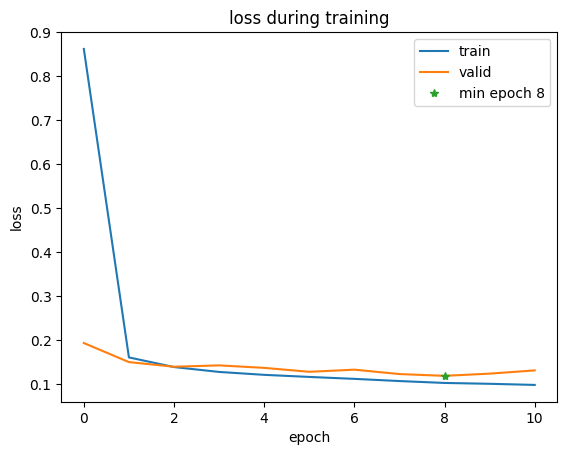

Epoch 11: 100%|██████████| 157/157 [00:06<00:00, 22.56it/s]


[Train] MSE loss: 0.095
[Valid] MSE loss: 0.116


Epoch 12: 100%|██████████| 157/157 [00:07<00:00, 21.24it/s]


[Train] MSE loss: 0.093
[Valid] MSE loss: 0.120


Epoch 13: 100%|██████████| 157/157 [00:07<00:00, 22.10it/s]


[Train] MSE loss: 0.090
[Valid] MSE loss: 0.118


Epoch 14: 100%|██████████| 157/157 [00:06<00:00, 22.91it/s]


[Train] MSE loss: 0.088
[Valid] MSE loss: 0.132


Epoch 15: 100%|██████████| 157/157 [00:07<00:00, 21.87it/s]


[Train] MSE loss: 0.088
[Valid] MSE loss: 0.130


Epoch 16: 100%|██████████| 157/157 [00:07<00:00, 21.02it/s]


[Train] MSE loss: 0.086
[Valid] MSE loss: 0.120


Epoch 17: 100%|██████████| 157/157 [00:07<00:00, 21.78it/s]


[Train] MSE loss: 0.083
[Valid] MSE loss: 0.116


Epoch 18: 100%|██████████| 157/157 [00:06<00:00, 23.50it/s]


[Train] MSE loss: 0.085
[Valid] MSE loss: 0.111


Epoch 19: 100%|██████████| 157/157 [00:07<00:00, 22.19it/s]


[Train] MSE loss: 0.080
[Valid] MSE loss: 0.123


Epoch 20: 100%|██████████| 157/157 [00:06<00:00, 22.68it/s]


[Train] MSE loss: 0.080
[Valid] MSE loss: 0.131


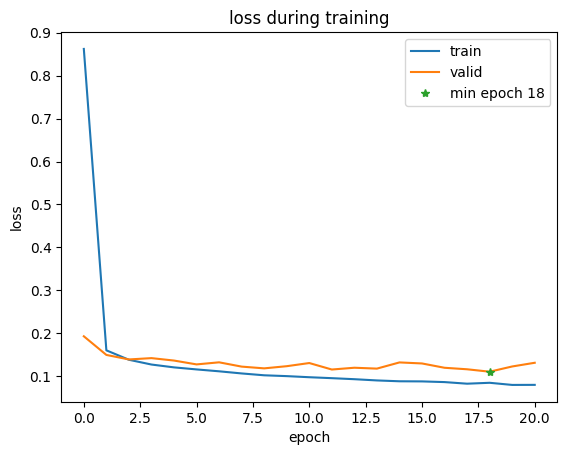

Epoch 21: 100%|██████████| 157/157 [00:06<00:00, 23.56it/s]


[Train] MSE loss: 0.077
[Valid] MSE loss: 0.117


Epoch 22: 100%|██████████| 157/157 [00:06<00:00, 22.88it/s]


[Train] MSE loss: 0.076
[Valid] MSE loss: 0.113


Epoch 23: 100%|██████████| 157/157 [00:06<00:00, 23.16it/s]


[Train] MSE loss: 0.076
[Valid] MSE loss: 0.112


Epoch 24: 100%|██████████| 157/157 [00:06<00:00, 22.92it/s]


[Train] MSE loss: 0.073
[Valid] MSE loss: 0.125


Epoch 25: 100%|██████████| 157/157 [00:06<00:00, 24.17it/s]


[Train] MSE loss: 0.072
[Valid] MSE loss: 0.111


Epoch 26: 100%|██████████| 157/157 [00:06<00:00, 23.36it/s]


[Train] MSE loss: 0.070
[Valid] MSE loss: 0.111


Epoch 27: 100%|██████████| 157/157 [00:06<00:00, 23.09it/s]


[Train] MSE loss: 0.071
[Valid] MSE loss: 0.143


Epoch 28: 100%|██████████| 157/157 [00:06<00:00, 23.62it/s]


[Train] MSE loss: 0.072
[Valid] MSE loss: 0.132


Epoch 29: 100%|██████████| 157/157 [00:06<00:00, 23.81it/s]


[Train] MSE loss: 0.069
[Valid] MSE loss: 0.114
early stop, no decrease


In [ ]:
if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt.pt', map_location=device))

for epoch in range(best_epoch, epochs+best_epoch):
    total_loss = 0
    model.train()
    for i, (fp, label) in tqdm(enumerate(train_loader),
                               total=len(train_loader),
                               desc=f'Epoch {epoch}'):
        optimizer.zero_grad()
        if cuda: fp, label = fp.cuda(), label.cuda()
        output = model(fp)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_df)
    print(f'[Train] MSE loss: {total_loss:.3f}')
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_valid_loss = 0
    for fp, label in valid_loader:
        if cuda: fp, label = fp.cuda(), label.cuda()
        output = model(fp)
        loss = loss_function(output, label)
        total_valid_loss += loss.item()
    total_valid_loss /= len(valid_df)
    valid_loss_dict[epoch] = total_valid_loss
    print(f'[Valid] MSE loss: {total_valid_loss:.3f}')
    argmin, min_loss = get_min(valid_loss_dict)
    if total_valid_loss <= min_loss and epoch > 3:
        # SAVE MODEL
        torch.save(model.state_dict(), 'ckpt.pt')
        best_epoch = epoch

    if epoch - argmin > 10: print('early stop, no decrease'); break
    if total_valid_loss / min_loss > 1.5: print('loss increase'); break

    if epoch % 10 == 0 and epoch != 0:
        plot_loss(train_loss_dict, valid_loss_dict, name='valid')

### Evaluate on test set. Reload model

In [ ]:
model = Classifier(dims)
if cuda: model = model.cuda()
model.load_state_dict(torch.load('ckpt.pt', map_location=device))

<All keys matched successfully>

Evaluate on test set


100%|██████████| 40/40 [00:01<00:00, 20.86it/s]



[Valid] MSE loss: 0.109



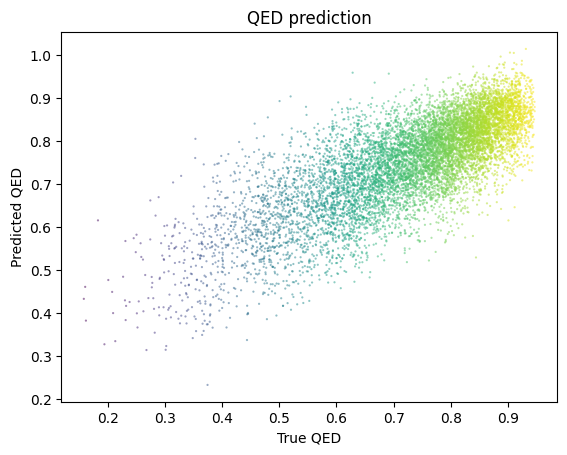

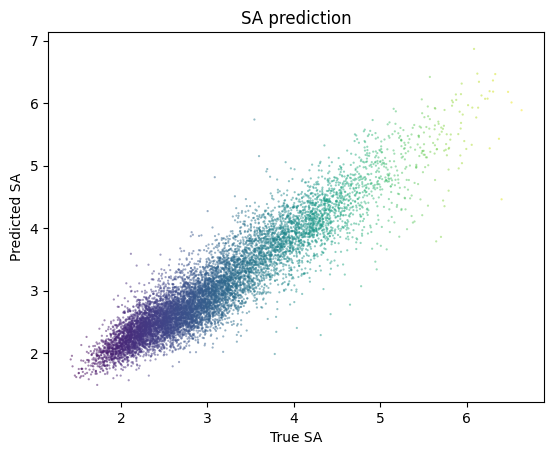

In [ ]:
print('Evaluate on test set')
total_test_loss = 0
model.eval()
for idx, (fp, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    if cuda: fp, label = fp.cuda(), label.cuda()
    output = model(fp)
    if idx == 0:
        outputs = output.cpu()
        labels = label.cpu()
    else:
        outputs = torch.cat([outputs, output.cpu()], dim=0)
        labels = torch.cat([labels, label.cpu()], dim=0)
    loss = loss_function(output, label)
    total_test_loss += loss.item()
total_test_loss /= len(test_df)
print()
print(f'[Test] MSE loss: {total_test_loss:.3f}')
print()
outputs, labels = outputs.detach().numpy(), labels.numpy()

from mycolorpy import colorlist as mcp

for i, j in enumerate(property_names):
    color = mcp.gen_color_normalized(cmap='viridis', data_arr=labels[:,i])
    plt.scatter(labels[:,i], outputs[:,i], cmap='viridis', marker='.',
            s=10, alpha=0.5, edgecolors='none', c=color)
    plt.xlabel(f'True {j}')
    plt.ylabel(f'Predicted {j}')
    plt.title(f'{j} prediction')
    plt.show()
    plt.close()